<h2> ARCTIC data reduction and photometric solutions</h2>

This notebook demonstrates some basic data reduction for ARCTIC imaging. It demonstrates how you can use plate solving to automatically find objects, e.g., standard stars. It also gives a simple aperture photometry routine. Finally, it does photometry over a series of different images in different filters and demonstrates simple photometric transformations from instrumental magnitudes to standard magnitudes with an airmass term, a transformation term, and a zeropoint; it does this for 5 SDSS filters.



Start with usual setup, importing required packages

In [1]:
from pyvista import tv,imred,stars
from holtztools import plots
import numpy as np
import matplotlib.pyplot as plt
import importlib
import matplotlib
from astropy.table import Table, vstack

/home/holtz/git/pyvista/python/pyvista/imred.py:1165: SyntaxWarning: invalid escape sequence '\s'
  plots.plotp(ax[0],mean,std**2,yt='$\sigma^2$',size=30,color=colors[icolor])
/home/holtz/git/pyvista/python/pyvista/imred.py:1166: SyntaxWarning: invalid escape sequence '\s'
  plots.plotp(ax[1],mean,2*mean/std**2,yt='G = 2 C / $\sigma^2$',size=20,color=colors[icolor])


In [2]:
# you may need/want to use qt or osx in the next line
%matplotlib tk 
t=tv.TV()

Instantiate a Reducer. Since the setup file is for 2x2, change the scale manually. (Note for bias subtraction to work correctly in 4x4, need to use overscan regions as specified in the headers; new version of Reducer allows for this, with headerbox attribute.)

In [13]:
importlib.reload(imred)
red=imred.Reducer('ARCTIC',conf='quad',dir='/home/holtz/raw/apo/oct23/UT231023/arctic')
red.scale=0.44
print('headerbox: ',red.headerbox)
red.normbox[0].set(550,750,550,750)
red.normbox[0].show()

/home/holtz/git/pyvista/python/pyvista/imred.py:1165: SyntaxWarning: invalid escape sequence '\s'
  plots.plotp(ax[0],mean,std**2,yt='$\sigma^2$',size=30,color=colors[icolor])
/home/holtz/git/pyvista/python/pyvista/imred.py:1166: SyntaxWarning: invalid escape sequence '\s'
  plots.plotp(ax[1],mean,2*mean/std**2,yt='G = 2 C / $\sigma^2$',size=20,color=colors[icolor])


INSTRUMENT: ARCTIC   config: quad
  will use format:  /home/holtz/raw/apo/oct23/UT231023/arctic/*{:04d}.f*.fits*
         gain:  [2.0]    rn: [3.7]
         scale:  0.228   
  Biastype : 1
  Bias box: 
    SC    NC    SR    NR
  1026    26    20   981 
  1026    26  1050   979 
  1052    24    20   981 
  1052    24  1050   979 
  Trim box: 
    SC    NC    SR    NR
     2  1024     0  1024 
     2  1024  1026  1024 
  1076  1024     0  1024 
  1076  1024  1026  1024 
  Norm box: 
    SC    NC    SR    NR
   800   201   800   201 
headerbox:  True
    SC    NC    SR    NR
   550   201   550   201 


Get the image log from headers. This is useful to have to search through to find images, e.g. through a particular filter, etc.

In [14]:
%time log=red.log()
log.pprint_all()

CPU times: user 830 ms, sys: 245 ms, total: 1.07 s
Wall time: 10.7 s
       FILE                DATE-OBS           OBJNAME       RA        DEC     FILTER EXPTIME
----------------- -------------------------- --------- ----------- ---------- ------ -------
    cal.0001.fits 2023-10-23T04:57:39.479077 chart_129 20:42:52.00 0:15:30.00 SDSS z     2.0
    cal.0002.fits 2023-10-23T04:57:39.479077 chart_129 20:42:52.00 0:15:30.00 SDSS z     2.0
    cal.0003.fits 2023-10-23T04:57:39.479077 chart_129 20:42:52.00 0:15:30.00 SDSS z     2.0
    cal.0004.fits 2023-10-23T04:57:39.479077 chart_129 20:42:52.00 0:15:30.00 SDSS z     2.0
    cal.0005.fits 2023-10-23T04:57:39.479077 chart_129 20:42:52.00 0:15:30.00 SDSS z     2.0
    cal.0006.fits 2023-10-23T04:57:39.479077 chart_129 20:42:52.00 0:15:30.00 SDSS z     2.0
    cal.0007.fits 2023-10-23T04:57:39.479077 chart_129 20:42:52.00 0:15:30.00 SDSS z     2.0
    cal.0008.fits 2023-10-23T04:57:39.479077 chart_129 20:42:52.00 0:15:30.00 SDSS z     2.0
 

Get the filter names from the headers

In [4]:
set(log['FILTER'])

{'CUVR', 'SDSS g#2', 'SDSS i', 'SDSS r#1', 'SDSS u', 'SDSS z'}

Specifiy the image numbers of the twilight flats in each filter. Set correspondence of simple filter names to header filter names.

In [5]:
twiframes=[]
twiframes.append(range(34,41+1))  #u
twiframes.append(range(65,70+1))  # g
twiframes.append(range(71,76+1))  # r
twiframes.append(range(77,86+1))  # i
twiframes.append(range(42,64+1)) #z
bias=np.arange(87,97+1)
filts=['u','g','r','i','z']
filtnames=['SDSS u','SDSS g#2','SDSS r#1','SDSS i','SDSS z']

Create the flats for each filter, and load into a flat dictionary. Inspect each componentm and modify twilight flat list as needed to remove bad frames.

In [21]:
flat={}
red.trim = True
for filt,frames in zip(filts,twiframes) :
    flat[filt] = red.mkflat(frames,display=None)

  Reading file: /home/holtz/raw/apo/oct23/UT231023/arctic/cal.0034.fits
  subtracting overscan vector 
  subtracting overscan vector 
  subtracting overscan vector 
  subtracting overscan vector 
INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]
  Reading file: /home/holtz/raw/apo/oct23/UT231023/arctic/cal.0035.fits
  subtracting overscan vector 
  subtracting overscan vector 
  subtracting overscan vector 
  subtracting overscan vector 
INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]
  Reading file: /home/holtz/raw/apo/oct23/UT231023/arctic/cal.0036.fits
  subtracting overscan vector 
  subtracting overscan vector 
  subtracting overscan vector 
  subtracting overscan vector 
INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]
  Reading file: /home/holtz/raw/apo/oct23/UT231023/arctic/cal.0037.fits
  subtracting overscan vector 
  subtractin

In [24]:
im=red.reduce(114,flat=flat['g'])
im.shape

  Reading file: /home/holtz/raw/apo/oct23/UT231023/arctic/science.0114.fits
  subtracting overscan vector 
  subtracting overscan vector 
  subtracting overscan vector 
  subtracting overscan vector 
INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]
  flat fielding...


(1024, 1024)

Get the positions and magnitudes of standard stars

In [18]:
tab=Table.read('ugriz_smith.fits')
#table formatting
for col in ['u','g','r','i','z'] : tab[col].info.format='.2f'
for col in ['RA','DEC'] : tab[col].info.format='.6f'
tab


NAME,RA,DEC,u,g,r,i,z,ID
bytes11,float64,float64,float64,float64,float64,float64,float64,int64
Hilt 31,7.046458,64.131056,12.58,11.58,11.00,10.70,10.55,1
G 158-100,8.477500,-12.133028,16.30,15.20,14.69,14.47,14.38,2
BD+71 0031,10.934750,72.178639,11.25,10.35,10.09,10.01,10.00,3
SA 92 342,13.791250,0.720250,12.85,11.78,11.53,11.48,11.49,4
SA 92 263,13.914208,0.605556,14.50,12.27,11.47,11.16,10.99,5
SA 92 502,14.033875,1.073639,13.03,12.00,11.71,11.63,11.62,6
SA 92 282,14.195250,0.641917,14.07,13.07,12.94,12.91,12.92,7
SA 92 288,14.320833,0.613528,13.78,12.01,11.35,11.12,11.02,8
SA 93 317,28.657208,0.716806,12.82,11.75,11.44,11.35,11.35,9


Define a function to read/reduce a frame, solve for WCS, find standard stars on frame, recenter, and do photometry

In [19]:
import os
def dophot(im,tab_phot, display, inter=False) :

    # populate x and y columns with pixel locations in this image
    tab['x'],tab['y']=im.wcs.wcs_world2pix(tab['RA'],tab['DEC'],0)

    nrow,ncol=im.data.shape
    gd=np.where((tab['x']>0)&(tab['y']>0)&(tab['x']<ncol)&(tab['y']<nrow))[0]
    if display is not None :
        display.tvclear()
        display.tv(im)
        for xx,yy in zip(tab[gd]['x'],tab[gd]['y']) : 
            display.tvcirc(xx,yy,20)

    phot=stars.mark(t,tab[gd],rad=3/red.scale,auto=True,exit=True)
    stars.photom(im,phot,rad=[10],skyrad=[20,30],display=display)
    tab_phot=vstack([tab_phot,phot])
    
    if inter : 
        phot.pprint()
        display.imexam()
        
    return tab_phot

Demo reduction of a single image, showing overscan subtraction, flat fielding, and plate solving

In [20]:
im=red.reduce(114,flat=flat['g'],solve=True,display=t)

  Reading file: /home/holtz/raw/apo/oct23/UT231023/arctic/science.0114.fits
  subtracting overscan vector 
  subtracting overscan vector 
  subtracting overscan vector 
  subtracting overscan vector 
  See bias box (solid outlines applied to dashed regions of the same color), and cross section. 
   To continue, hit space in display window (p for debug) 
  flat fielding...
  See flat-fielded image and original with - (minus) key.
   To continue, hit space in display window (p for debug) 
INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]
  plate solving with local astrometry.net....
found  39  objects 
/usr/local/astrometry/bin/solve-field --scale-units arcsecperpix --scale-low 0.396000 --scale-high 0.484000 -X xcentroid -Y ycentroid -w 4800 -e 3000 --overwrite --ra 340.400000 --dec 1.183333 --radius 3 tmp4hq_qac5xy.fits
Reading input file 1 of 1: "tmp4hq_qac5xy.fits"...


(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.VDwo5G -i ./tmp4hq_qac5xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmp4hq_qac5xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmp4hq_qac5xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmp4hq_qac5xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (340.4,1.18333)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4206-04.fits, field objects 1-10).
Field 1 did not solve (index index-4205-04.fits, field objects 1-10).
Field 1 did not solve (index index-4204-17.fits, field objects 1-10).

Show the derived WCS header cards

In [21]:
im.wcs.to_header(relax=True)

WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =        260.057435779 / Pixel coordinate of reference point            
CRPIX2  =        715.468142222 / Pixel coordinate of reference point            
PC1_1   =   -0.000127366978357 / Coordinate transformation matrix element       
PC1_2   =    2.77109580862E-07 / Coordinate transformation matrix element       
PC2_1   =   -5.08866450499E-07 / Coordinate transformation matrix element       
PC2_2   =    0.000127027259382 / Coordinate transformation matrix element       
CDELT1  =                  1.0 / [deg] Coordinate increment at reference point  
CDELT2  =                  1.0 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CTYPE1  = 'RA---TAN-SIP'       / TAN (gnomonic) projection + SIP distortions    
CTYPE2  = 'DEC--TAN-SIP'    

Demo identification of standards and aperture photometry on one image

In [22]:
tab_phot=[]
dophot(im,tab_phot,t,inter=True) 

   NAME        RA       DEC      u     g   ... aper10err  sky  skysig   peak 
---------- ---------- -------- ----- ----- ... --------- ----- ------ -------
SA 114 654 340.358917 1.169639 13.52 12.12 ...     0.002 32.04   4.55 51442.5
SA 114 656 340.396083 1.186056 15.04 13.08 ...     0.002 29.59   4.31 24654.8
SA 114 750 340.436250 1.210056 12.36 11.81 ...     0.002 30.89   4.54 31993.1
Hit key near star center, "q" to quit
xFWHM:    1.91   yFWHM:    1.84   FWHM:    1.87  SCALE:    1.00  PA:   44.31


col0,NAME,RA,DEC,u,g,r,i,z,ID,x,y,EXPTIME,FILTER,AIRMASS,MJD,aper10,aper10err,sky,skysig,peak
float64,bytes11,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,str8,float64,float64,float64,float64,float64,float64,float64
--,SA 114 654,340.358917,1.169639,13.52,12.12,11.67,11.54,11.50,147,847.67253231282,426.9002558517414,0.5,SDSS r#1,1.173,60240.148217,-13.368,0.002,32.04,4.55,51442.5
--,SA 114 656,340.396083,1.186056,15.04,13.08,12.33,12.03,11.88,148,555.7278231774766,556.6789690054899,0.5,SDSS r#1,1.173,60240.148217,-12.666,0.002,29.59,4.31,24654.8
--,SA 114 750,340.436250,1.210056,12.36,11.81,12.02,12.25,12.41,150,240.124476578384,744.6745382394387,0.5,SDSS r#1,1.173,60240.148217,-12.968,0.002,30.89,4.54,31993.1


<h3> Aperture photometry and photometric solution </h3>

Now run it for all of the frames of a given filter! Will take a little while with the plate solving. Note you could modify the for loop to do every nth frame for a quick test, etc....

In [24]:
tab_phot=[]             # initialize final photometry table, the table for each image will be appended to this
matplotlib.use('Agg')   # this will turn off display
t=tv.TV()
for filt,filtname in zip(filts,filtnames) :
    frames=np.where((log['FILTER'] == filtname) & (np.char.find(log['FILE'],b'science') >=0) )[0]
    print(filt,filtname,frames)
    for frame in frames :
        print(frame)
        try :
            file = log['FILE'][frame]
            print(file)
            im=red.reduce(log['FILE'][frame],flat=flat[filt],solve=True)
            print('done reduce')
            try: os.mkdir(red.dir+'/red')
            except : pass
            im.write(red.dir+'/red/{:s}'.format(file))

            tab_phot = dophot(im,tab_phot,t)
        except : 
            continue

/tmp/ipykernel_8435/1138146759.py:2: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed in 3.10.  To suppress this warning, explicitly call plt.close('all') first.
  matplotlib.use('Agg')   # this will turn off display


u SDSS u [118 119 120 121 124 125 126 139 140 141 154 155 156 164 165 166 179 180
 181 200 201 202 216 217 218 233 234 235]
118
science.0119.fits
  Reading file: /home/holtz/raw/apo/oct23/UT231023/arctic/science.0119.fits
  subtracting overscan vector 
  subtracting overscan vector 
  subtracting overscan vector 
  subtracting overscan vector 
  flat fielding...
INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]
  plate solving with local astrometry.net....
found  19  objects 
/usr/local/astrometry/bin/solve-field --scale-units arcsecperpix --scale-low 0.396000 --scale-high 0.484000 -X xcentroid -Y ycentroid -w 4800 -e 3000 --overwrite --ra 340.400000 --dec 1.183333 --radius 3 tmp_0cizcnkxy.fits
Reading input file 1 of 1: "tmp_0cizcnkxy.fits"...


(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.42BRaQ -i ./tmp_0cizcnkxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmp_0cizcnkxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmp_0cizcnkxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmp_0cizcnkxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (340.4,1.18333)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4206-04.fits, field objects 1-10).
Field 1 did not solve (index index-4205-04.fits, field objects 1-10).
Field 1 did not solve (index index-4204-17.fits, field objects 1-10).

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.jAh0wH -i ./tmpzwwfbkgjxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpzwwfbkgjxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpzwwfbkgjxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpzwwfbkgjxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (340.4,1.18333)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4206-04.fits, field objects 1-10).
Field 1 did not solve (index index-4205-04.fits, field objects 1-10).
Field 1 did not solve (index index-4204-17.fits, field objects 1-10).

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.HX2rd7 -i ./tmp15togfpkxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmp15togfpkxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmp15togfpkxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmp15togfpkxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (340.4,1.18333)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4206-04.fits, field objects 1-10).
Field 1 did not solve (index index-4205-04.fits, field objects 1-10).
Field 1 did not solve (index index-4204-17.fits, field objects 1-10).

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.zsi17w -i ./tmpod16g_qwxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpod16g_qwxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpod16g_qwxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpod16g_qwxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (340.4,1.18333)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4206-04.fits, field objects 1-10).
Field 1 did not solve (index index-4205-04.fits, field objects 1-10).
Field 1 did not solve (index index-4204-17.fits, field objects 1-10).

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.M8FuEj -i ./tmp2ts78k2pxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmp2ts78k2pxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmp2ts78k2pxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmp2ts78k2pxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (44.3917,0.3)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-00.fits, field objects 1-10).
F

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.t3n1iC -i ./tmp_5htcf2vxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmp_5htcf2vxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmp_5htcf2vxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmp_5htcf2vxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (44.3917,0.3)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-00.fits, field objects 1-10).
F

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.zv7HrE -i ./tmpawbswpjrxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpawbswpjrxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpawbswpjrxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpawbswpjrxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (44.3917,0.3)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-00.fits, field objects 1-10).
F

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.CPl9Sk -i ./tmpg6kuz2rlxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpg6kuz2rlxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpg6kuz2rlxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpg6kuz2rlxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (44.3917,0.3)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-00.fits, field objects 1-10).
F

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.62w9wG -i ./tmp1wuvl5_uxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmp1wuvl5_uxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmp1wuvl5_uxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmp1wuvl5_uxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (44.3917,0.3)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-00.fits, field objects 1-10).
F

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.xQLMNi -i ./tmp3txp_t6jxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmp3txp_t6jxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmp3txp_t6jxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmp3txp_t6jxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (44.3917,0.3)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-00.fits, field objects 1-10).
F

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.kEeXst -i ./tmpq7x_30kmxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpq7x_30kmxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpq7x_30kmxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpq7x_30kmxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.708,0.266667)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.tqahNZ -i ./tmpau34jqxuxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpau34jqxuxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpau34jqxuxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpau34jqxuxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.708,0.266667)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.rbFrUD -i ./tmpsgs_ctuoxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpsgs_ctuoxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpsgs_ctuoxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpsgs_ctuoxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.708,0.266667)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.vi11dh -i ./tmpbug77rcdxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpbug77rcdxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpbug77rcdxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpbug77rcdxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.721,0.254167)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.QtYE0M -i ./tmprbx97fktxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmprbx97fktxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmprbx97fktxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmprbx97fktxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.721,0.254167)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.NZKcQm -i ./tmppwqiwc7oxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmppwqiwc7oxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmppwqiwc7oxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmppwqiwc7oxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.721,0.254167)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.EhwHAz -i ./tmpudcm4gsmxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpudcm4gsmxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpudcm4gsmxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpudcm4gsmxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.721,0.254167)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.x3ZBZA -i ./tmpqyy0gltexy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpqyy0gltexy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpqyy0gltexy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpqyy0gltexy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.721,0.254167)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.eSX1Jv -i ./tmp2vxlr3rzxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmp2vxlr3rzxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmp2vxlr3rzxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmp2vxlr3rzxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.721,0.254167)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.tQg2aJ -i ./tmp30siblknxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmp30siblknxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmp30siblknxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmp30siblknxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (340.392,1.19167)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4206-04.fits, field objects 1-10).
Field 1 did not solve (index index-4205-04.fits, field objects 1-10).
Field 1 did not solve (index index-4204-17.fits, field objects 1-10

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.0oDe0E -i ./tmp13udf88bxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmp13udf88bxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmp13udf88bxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmp13udf88bxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (340.392,1.19167)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4206-04.fits, field objects 1-10).
Field 1 did not solve (index index-4205-04.fits, field objects 1-10).
Field 1 did not solve (index index-4204-17.fits, field objects 1-10

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.VqDnUG -i ./tmpbydb2u6mxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpbydb2u6mxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpbydb2u6mxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpbydb2u6mxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (340.392,1.19167)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4206-04.fits, field objects 1-10).
Field 1 did not solve (index index-4205-04.fits, field objects 1-10).
Field 1 did not solve (index index-4204-17.fits, field objects 1-10

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.ZS88ll -i ./tmp9cgui2b0xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmp9cgui2b0xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmp9cgui2b0xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmp9cgui2b0xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (44.3917,0.3)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-00.fits, field objects 1-10).
F

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.wmHxWC -i ./tmpomy957x0xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpomy957x0xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpomy957x0xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpomy957x0xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (44.3917,0.3)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-00.fits, field objects 1-10).
F

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.pyGLaO -i ./tmptg2e39a4xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmptg2e39a4xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmptg2e39a4xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmptg2e39a4xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (44.3917,0.3)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-00.fits, field objects 1-10).
F

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.JsuFxX -i ./tmpx_6fvh3cxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpx_6fvh3cxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpx_6fvh3cxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpx_6fvh3cxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.717,0.258333)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.kXA8dL -i ./tmp94vqe3lexy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmp94vqe3lexy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmp94vqe3lexy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmp94vqe3lexy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.717,0.258333)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.T2WaA6 -i ./tmpyvzkdf4ixy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpyvzkdf4ixy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpyvzkdf4ixy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpyvzkdf4ixy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.717,0.258333)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.W4nHsj -i ./tmpzo_8pml8xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpzo_8pml8xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpzo_8pml8xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpzo_8pml8xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (340.4,1.18333)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4206-04.fits, field objects 1-10).
Field 1 did not solve (index index-4205-04.fits, field objects 1-10).
Field 1 did not solve (index index-4204-17.fits, field objects 1-10).

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.Eg2pkl -i ./tmpohb7e1k1xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpohb7e1k1xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpohb7e1k1xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpohb7e1k1xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (340.4,1.18333)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4206-04.fits, field objects 1-10).
Field 1 did not solve (index index-4205-04.fits, field objects 1-10).
Field 1 did not solve (index index-4204-17.fits, field objects 1-10).

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.KS9yrX -i ./tmprcs_wchkxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmprcs_wchkxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmprcs_wchkxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmprcs_wchkxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (340.4,1.18333)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4206-04.fits, field objects 1-10).
Field 1 did not solve (index index-4205-04.fits, field objects 1-10).
Field 1 did not solve (index index-4204-17.fits, field objects 1-10).

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.bdMjnF -i ./tmpeh4n6w08xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpeh4n6w08xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpeh4n6w08xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpeh4n6w08xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (340.4,1.18333)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4206-04.fits, field objects 1-10).
Field 1 did not solve (index index-4205-04.fits, field objects 1-10).
Field 1 did not solve (index index-4204-17.fits, field objects 1-10).

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.khA8M8 -i ./tmpa5x8t4a1xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpa5x8t4a1xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpa5x8t4a1xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpa5x8t4a1xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (340.4,1.18333)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4206-04.fits, field objects 1-10).
Field 1 did not solve (index index-4205-04.fits, field objects 1-10).
Field 1 did not solve (index index-4204-17.fits, field objects 1-10).

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.SPs13O -i ./tmp3nxbi4jsxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmp3nxbi4jsxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmp3nxbi4jsxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmp3nxbi4jsxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (44.3917,0.3)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-00.fits, field objects 1-10).
F

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.6HXIIF -i ./tmp57_z8pp7xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmp57_z8pp7xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmp57_z8pp7xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmp57_z8pp7xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (44.3917,0.3)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-00.fits, field objects 1-10).
F

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.FbBbrE -i ./tmp8ve1v5s3xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmp8ve1v5s3xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmp8ve1v5s3xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmp8ve1v5s3xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (44.3917,0.3)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-00.fits, field objects 1-10).
F

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.pgQ0cV -i ./tmpgc7lf7u5xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpgc7lf7u5xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpgc7lf7u5xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpgc7lf7u5xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (44.3917,0.3)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-00.fits, field objects 1-10).
F

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.93fqQw -i ./tmpz5mlnt9bxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpz5mlnt9bxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpz5mlnt9bxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpz5mlnt9bxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (44.3917,0.3)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-00.fits, field objects 1-10).
F

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.yZbjoH -i ./tmp_hel68ynxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmp_hel68ynxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmp_hel68ynxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmp_hel68ynxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (44.3917,0.3)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-00.fits, field objects 1-10).
F

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.6ujmq1 -i ./tmp17rityj6xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmp17rityj6xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmp17rityj6xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmp17rityj6xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (44.3917,0.3)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-00.fits, field objects 1-10).
F

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.wwOOgp -i ./tmpguil4g4xxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpguil4g4xxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpguil4g4xxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpguil4g4xxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (44.3917,0.3)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-00.fits, field objects 1-10).
F

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.Ug8VyY -i ./tmp0i9cu314xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmp0i9cu314xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmp0i9cu314xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmp0i9cu314xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.708,0.266667)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.UeVuCu -i ./tmp3ywop09yxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmp3ywop09yxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmp3ywop09yxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmp3ywop09yxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.708,0.266667)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.QkwII8 -i ./tmpxk353cdyxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpxk353cdyxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpxk353cdyxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpxk353cdyxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.708,0.266667)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.lUFwdf -i ./tmpejtx5m_hxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpejtx5m_hxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpejtx5m_hxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpejtx5m_hxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.721,0.254167)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.h4bJ90 -i ./tmpf7tfdp3ixy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpf7tfdp3ixy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpf7tfdp3ixy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpf7tfdp3ixy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.721,0.254167)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.4mKFYp -i ./tmpmvmmecaexy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpmvmmecaexy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpmvmmecaexy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpmvmmecaexy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.721,0.254167)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.7DHAxF -i ./tmprmvndx4txy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmprmvndx4txy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmprmvndx4txy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmprmvndx4txy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.721,0.254167)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.bx6tJ0 -i ./tmpf49_uozvxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpf49_uozvxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpf49_uozvxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpf49_uozvxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.721,0.254167)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.31Akws -i ./tmp9edemqsvxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmp9edemqsvxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmp9edemqsvxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmp9edemqsvxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.721,0.254167)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.t0R9zG -i ./tmp3gjz3b9exy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmp3gjz3b9exy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmp3gjz3b9exy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmp3gjz3b9exy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (340.392,1.19167)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4206-04.fits, field objects 1-10).
Field 1 did not solve (index index-4205-04.fits, field objects 1-10).
Field 1 did not solve (index index-4204-17.fits, field objects 1-10

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.g5cRsF -i ./tmptgijakz4xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmptgijakz4xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmptgijakz4xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmptgijakz4xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (340.392,1.19167)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4206-04.fits, field objects 1-10).
Field 1 did not solve (index index-4205-04.fits, field objects 1-10).
Field 1 did not solve (index index-4204-17.fits, field objects 1-10

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.c0brGq -i ./tmplos_8qy9xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmplos_8qy9xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmplos_8qy9xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmplos_8qy9xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (340.392,1.19167)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4206-04.fits, field objects 1-10).
Field 1 did not solve (index index-4205-04.fits, field objects 1-10).
Field 1 did not solve (index index-4204-17.fits, field objects 1-10

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.i0Q8eS -i ./tmpfd3mn813xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpfd3mn813xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpfd3mn813xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpfd3mn813xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (44.3917,0.3)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-00.fits, field objects 1-10).
F

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.jM12bb -i ./tmpg5t2t8glxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpg5t2t8glxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpg5t2t8glxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpg5t2t8glxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (44.3917,0.3)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-00.fits, field objects 1-10).
F

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.5hhXoh -i ./tmpu8nyyi89xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpu8nyyi89xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpu8nyyi89xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpu8nyyi89xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (44.3917,0.3)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-00.fits, field objects 1-10).
F

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.LT6K2I -i ./tmpewvf2py4xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpewvf2py4xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpewvf2py4xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpewvf2py4xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.717,0.258333)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.k6bRCZ -i ./tmp50fk4k83xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmp50fk4k83xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmp50fk4k83xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmp50fk4k83xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.717,0.258333)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.KUbIF9 -i ./tmp1bbcvk82xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmp1bbcvk82xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmp1bbcvk82xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmp1bbcvk82xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.717,0.258333)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.eboFvx -i ./tmpzpxa0cn4xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpzpxa0cn4xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpzpxa0cn4xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpzpxa0cn4xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (340.4,1.18333)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4206-04.fits, field objects 1-10).
Field 1 did not solve (index index-4205-04.fits, field objects 1-10).
Field 1 did not solve (index index-4204-17.fits, field objects 1-10).

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.MhbrBT -i ./tmppjv791kgxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmppjv791kgxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmppjv791kgxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmppjv791kgxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (340.4,1.18333)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4206-04.fits, field objects 1-10).
Field 1 did not solve (index index-4205-04.fits, field objects 1-10).
Field 1 did not solve (index index-4204-17.fits, field objects 1-10).

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.O4rjQq -i ./tmp9qoe807gxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmp9qoe807gxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmp9qoe807gxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmp9qoe807gxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (340.4,1.18333)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4206-04.fits, field objects 1-10).
Field 1 did not solve (index index-4205-04.fits, field objects 1-10).
Field 1 did not solve (index index-4204-17.fits, field objects 1-10).

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.dg6HZ4 -i ./tmp6zbh5li0xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmp6zbh5li0xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmp6zbh5li0xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmp6zbh5li0xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (340.4,1.18333)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4206-04.fits, field objects 1-10).
Field 1 did not solve (index index-4205-04.fits, field objects 1-10).
Field 1 did not solve (index index-4204-17.fits, field objects 1-10).

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.vGln1R -i ./tmpx_38xmhcxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpx_38xmhcxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpx_38xmhcxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpx_38xmhcxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (44.3917,0.3)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-00.fits, field objects 1-10).
F

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.KNv2Kd -i ./tmp718tptjxxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmp718tptjxxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmp718tptjxxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmp718tptjxxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (44.3917,0.3)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-00.fits, field objects 1-10).
F

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.P7LYAb -i ./tmp8uj18roxxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmp8uj18roxxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmp8uj18roxxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmp8uj18roxxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (44.3917,0.3)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-00.fits, field objects 1-10).
F

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.tbqKtE -i ./tmp_na7q1bpxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmp_na7q1bpxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmp_na7q1bpxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmp_na7q1bpxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (44.3917,0.3)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-00.fits, field objects 1-10).
F

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.CakZhV -i ./tmpa83tuu6cxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpa83tuu6cxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpa83tuu6cxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpa83tuu6cxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (44.3917,0.3)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-00.fits, field objects 1-10).
F

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.7ermmr -i ./tmpav1d7wjtxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpav1d7wjtxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpav1d7wjtxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpav1d7wjtxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (44.3917,0.3)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-00.fits, field objects 1-10).
F

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.pEEj6I -i ./tmpuv5ba7_oxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpuv5ba7_oxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpuv5ba7_oxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpuv5ba7_oxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.721,0.254167)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.IBy3Y7 -i ./tmpj963xbi5xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpj963xbi5xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpj963xbi5xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpj963xbi5xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.721,0.254167)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.JB5IEg -i ./tmpvy7y5zx6xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpvy7y5zx6xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpvy7y5zx6xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpvy7y5zx6xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.721,0.254167)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.QMPoJp -i ./tmpq64ofzglxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpq64ofzglxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpq64ofzglxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpq64ofzglxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.721,0.254167)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.SAIvDE -i ./tmpu6sjgq05xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpu6sjgq05xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpu6sjgq05xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpu6sjgq05xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.721,0.254167)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.S60DZa -i ./tmpqeqpdto7xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpqeqpdto7xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpqeqpdto7xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpqeqpdto7xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.721,0.254167)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.dOqxLD -i ./tmpmzz67uttxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpmzz67uttxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpmzz67uttxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpmzz67uttxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.721,0.254167)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.Cr1dlP -i ./tmp4rn65k9dxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmp4rn65k9dxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmp4rn65k9dxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmp4rn65k9dxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (340.392,1.19167)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4206-04.fits, field objects 1-10).
Field 1 did not solve (index index-4205-04.fits, field objects 1-10).
Field 1 did not solve (index index-4204-17.fits, field objects 1-10

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.JkCiTa -i ./tmpw7znnlxuxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpw7znnlxuxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpw7znnlxuxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpw7znnlxuxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (340.392,1.19167)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4206-04.fits, field objects 1-10).
Field 1 did not solve (index index-4205-04.fits, field objects 1-10).
Field 1 did not solve (index index-4204-17.fits, field objects 1-10

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.Nqw1az -i ./tmpj38qlknaxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpj38qlknaxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpj38qlknaxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpj38qlknaxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (340.392,1.19167)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4206-04.fits, field objects 1-10).
Field 1 did not solve (index index-4205-04.fits, field objects 1-10).
Field 1 did not solve (index index-4204-17.fits, field objects 1-10

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.gMMrky -i ./tmpkj7xu7_4xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpkj7xu7_4xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpkj7xu7_4xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpkj7xu7_4xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (44.3917,0.3)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-00.fits, field objects 1-10).
F

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.XuqQ7Q -i ./tmps_ezx9axxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmps_ezx9axxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmps_ezx9axxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmps_ezx9axxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (44.3917,0.3)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-00.fits, field objects 1-10).
F

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.2qMHx5 -i ./tmpgf_ybev9xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpgf_ybev9xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpgf_ybev9xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpgf_ybev9xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (44.3917,0.3)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-00.fits, field objects 1-10).
F

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.2PgDuv -i ./tmp5m8d0ivgxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmp5m8d0ivgxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmp5m8d0ivgxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmp5m8d0ivgxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.717,0.258333)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.mxrIhR -i ./tmpdqk6ws5nxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpdqk6ws5nxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpdqk6ws5nxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpdqk6ws5nxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.717,0.258333)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.85PXc6 -i ./tmpphesb1cyxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpphesb1cyxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpphesb1cyxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpphesb1cyxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.717,0.258333)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.7e1buE -i ./tmpruxfw__gxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpruxfw__gxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpruxfw__gxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpruxfw__gxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (340.4,1.18333)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4206-04.fits, field objects 1-10).
Field 1 did not solve (index index-4205-04.fits, field objects 1-10).
Field 1 did not solve (index index-4204-17.fits, field objects 1-10).

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.uC3QeV -i ./tmpixg_q6jkxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpixg_q6jkxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpixg_q6jkxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpixg_q6jkxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (340.4,1.18333)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4206-04.fits, field objects 1-10).
Field 1 did not solve (index index-4205-04.fits, field objects 1-10).
Field 1 did not solve (index index-4204-17.fits, field objects 1-10).

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.pMctl4 -i ./tmpqe52o3goxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpqe52o3goxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpqe52o3goxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpqe52o3goxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (340.4,1.18333)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4206-04.fits, field objects 1-10).
Field 1 did not solve (index index-4205-04.fits, field objects 1-10).
Field 1 did not solve (index index-4204-17.fits, field objects 1-10).

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.nkWyy0 -i ./tmpglyu9zqnxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpglyu9zqnxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpglyu9zqnxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpglyu9zqnxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (340.4,1.18333)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4206-04.fits, field objects 1-10).
Field 1 did not solve (index index-4205-04.fits, field objects 1-10).
Field 1 did not solve (index index-4204-17.fits, field objects 1-10).

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.x918fX -i ./tmpefeukyk1xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpefeukyk1xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpefeukyk1xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpefeukyk1xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (340.4,1.18333)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4206-04.fits, field objects 1-10).
Field 1 did not solve (index index-4205-04.fits, field objects 1-10).
Field 1 did not solve (index index-4204-17.fits, field objects 1-10).

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.TLwnIr -i ./tmpct7ko30_xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpct7ko30_xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpct7ko30_xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpct7ko30_xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (340.4,1.18333)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4206-04.fits, field objects 1-10).
Field 1 did not solve (index index-4205-04.fits, field objects 1-10).
Field 1 did not solve (index index-4204-17.fits, field objects 1-10).

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.6HxED0 -i ./tmpu4727vs4xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpu4727vs4xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpu4727vs4xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpu4727vs4xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (340.4,1.18333)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4206-04.fits, field objects 1-10).
Field 1 did not solve (index index-4205-04.fits, field objects 1-10).
Field 1 did not solve (index index-4204-17.fits, field objects 1-10).

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.R45JpC -i ./tmpfw6uv6v0xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpfw6uv6v0xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpfw6uv6v0xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpfw6uv6v0xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (44.3917,0.3)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-00.fits, field objects 1-10).
F

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.ig7JtW -i ./tmpllc1wmbyxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpllc1wmbyxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpllc1wmbyxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpllc1wmbyxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (44.3917,0.3)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-00.fits, field objects 1-10).
F

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.BWRu1e -i ./tmpl8ngsp_2xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpl8ngsp_2xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpl8ngsp_2xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpl8ngsp_2xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (44.3917,0.3)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-00.fits, field objects 1-10).
F

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.qq6f0V -i ./tmpzjc1r0u3xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpzjc1r0u3xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpzjc1r0u3xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpzjc1r0u3xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (44.3917,0.3)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-00.fits, field objects 1-10).
F

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.JmOiVn -i ./tmpkfayjr0fxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpkfayjr0fxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpkfayjr0fxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpkfayjr0fxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (44.3917,0.3)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-00.fits, field objects 1-10).
F

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.N9V8uy -i ./tmpc9t64t1zxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpc9t64t1zxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpc9t64t1zxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpc9t64t1zxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (44.3917,0.3)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-00.fits, field objects 1-10).
F

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.0pmGSS -i ./tmpvil0wp1sxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpvil0wp1sxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpvil0wp1sxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpvil0wp1sxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.708,0.266667)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.X183kN -i ./tmpqd_hfi96xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpqd_hfi96xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpqd_hfi96xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpqd_hfi96xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.708,0.266667)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.fIzb5v -i ./tmp91jovyd6xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmp91jovyd6xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmp91jovyd6xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmp91jovyd6xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.708,0.266667)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.hl94UY -i ./tmp1fvpqvccxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmp1fvpqvccxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmp1fvpqvccxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmp1fvpqvccxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.721,0.254167)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.GxpdUd -i ./tmpv96uzfg7xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpv96uzfg7xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpv96uzfg7xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpv96uzfg7xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.721,0.254167)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.0xLitk -i ./tmpg201gsklxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpg201gsklxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpg201gsklxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpg201gsklxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.721,0.254167)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.ouWNav -i ./tmpdk_ysl63xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpdk_ysl63xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpdk_ysl63xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpdk_ysl63xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.721,0.254167)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.2IV1W9 -i ./tmprxfusuehxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmprxfusuehxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmprxfusuehxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmprxfusuehxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.721,0.254167)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.5Zjdcj -i ./tmpd86updmbxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpd86updmbxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpd86updmbxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpd86updmbxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.721,0.254167)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.GsZSdM -i ./tmp3euuxgh_xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmp3euuxgh_xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmp3euuxgh_xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmp3euuxgh_xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (340.392,1.19167)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4206-04.fits, field objects 1-10).
Field 1 did not solve (index index-4205-04.fits, field objects 1-10).
  log-odds ratio 32.3688 (1.14175e+14), 5 match, 0 conflict, 1 dist

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.zqvCPo -i ./tmpyrv6oooixy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpyrv6oooixy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpyrv6oooixy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpyrv6oooixy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (340.392,1.19167)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4206-04.fits, field objects 1-10).
Field 1 did not solve (index index-4205-04.fits, field objects 1-10).
Field 1 did not solve (index index-4204-17.fits, field objects 1-10

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.doIB3Z -i ./tmp8oz2w87lxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmp8oz2w87lxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmp8oz2w87lxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmp8oz2w87lxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (340.392,1.19167)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4206-04.fits, field objects 1-10).
Field 1 did not solve (index index-4205-04.fits, field objects 1-10).
Field 1 did not solve (index index-4204-17.fits, field objects 1-10

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.q5xE1p -i ./tmpddb2dhfoxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpddb2dhfoxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpddb2dhfoxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpddb2dhfoxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (44.3917,0.3)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-00.fits, field objects 1-10).
F

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.ifRVBK -i ./tmpg92s8c_7xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpg92s8c_7xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpg92s8c_7xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpg92s8c_7xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (44.3917,0.3)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-00.fits, field objects 1-10).
F

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.QRX4ba -i ./tmpj4c8aq31xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpj4c8aq31xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpj4c8aq31xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpj4c8aq31xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (44.3917,0.3)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-00.fits, field objects 1-10).
F

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.aW5dPl -i ./tmpabkzchabxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpabkzchabxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpabkzchabxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpabkzchabxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.717,0.258333)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.hA4Psr -i ./tmpig_2h6mhxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpig_2h6mhxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpig_2h6mhxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpig_2h6mhxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.717,0.258333)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.5opWE7 -i ./tmpdb5boqy0xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpdb5boqy0xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpdb5boqy0xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpdb5boqy0xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.717,0.258333)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.r9cRAo -i ./tmpysai7hmuxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpysai7hmuxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpysai7hmuxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpysai7hmuxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (340.4,1.18333)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4206-04.fits, field objects 1-10).
Field 1 did not solve (index index-4205-04.fits, field objects 1-10).
Field 1 did not solve (index index-4204-17.fits, field objects 1-10).

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.w3lijY -i ./tmpyankb13fxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpyankb13fxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpyankb13fxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpyankb13fxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (340.4,1.18333)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4206-04.fits, field objects 1-10).
Field 1 did not solve (index index-4205-04.fits, field objects 1-10).
Field 1 did not solve (index index-4204-17.fits, field objects 1-10).

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.C5kevv -i ./tmpfs4phfgixy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpfs4phfgixy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpfs4phfgixy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpfs4phfgixy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (340.4,1.18333)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4206-04.fits, field objects 1-10).
Field 1 did not solve (index index-4205-04.fits, field objects 1-10).
Field 1 did not solve (index index-4204-17.fits, field objects 1-10).

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.NE5NF5 -i ./tmpuy30t4paxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpuy30t4paxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpuy30t4paxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpuy30t4paxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (340.4,1.18333)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4206-04.fits, field objects 1-10).
Field 1 did not solve (index index-4205-04.fits, field objects 1-10).
Field 1 did not solve (index index-4204-17.fits, field objects 1-10).

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.uMNq3y -i ./tmpuvjwdyekxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpuvjwdyekxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpuvjwdyekxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpuvjwdyekxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (44.3917,0.3)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-00.fits, field objects 1-10).
F

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.ivLT9P -i ./tmp4ga39j1xxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmp4ga39j1xxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmp4ga39j1xxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmp4ga39j1xxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (44.3917,0.3)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-00.fits, field objects 1-10).
F

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.QtaBx0 -i ./tmpu_v5ye9jxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpu_v5ye9jxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpu_v5ye9jxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpu_v5ye9jxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (44.3917,0.3)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-00.fits, field objects 1-10).
F

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.B9NedZ -i ./tmpb959g0wjxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpb959g0wjxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpb959g0wjxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpb959g0wjxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (44.3917,0.3)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-00.fits, field objects 1-10).
F

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.ee5Zck -i ./tmppu4gbopmxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmppu4gbopmxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmppu4gbopmxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmppu4gbopmxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (44.3917,0.3)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-00.fits, field objects 1-10).
F

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.2OSA2c -i ./tmpcv_vl5f_xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpcv_vl5f_xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpcv_vl5f_xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpcv_vl5f_xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (44.3917,0.3)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-00.fits, field objects 1-10).
F

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.ALZHYp -i ./tmpasq2nrmqxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpasq2nrmqxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpasq2nrmqxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpasq2nrmqxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.721,0.254167)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.kOQtcR -i ./tmp06wb4_tlxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmp06wb4_tlxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmp06wb4_tlxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmp06wb4_tlxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.721,0.254167)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.G4yTV8 -i ./tmp4a_5axkaxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmp4a_5axkaxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmp4a_5axkaxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmp4a_5axkaxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.721,0.254167)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.perv2n -i ./tmplkt603t_xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmplkt603t_xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmplkt603t_xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmplkt603t_xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.721,0.254167)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.hgokO8 -i ./tmp2llld1myxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmp2llld1myxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmp2llld1myxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmp2llld1myxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.721,0.254167)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.wJtzvh -i ./tmpm80d9jgqxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpm80d9jgqxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpm80d9jgqxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpm80d9jgqxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.721,0.254167)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.1QDQgH -i ./tmpjgdgf4lsxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpjgdgf4lsxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpjgdgf4lsxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpjgdgf4lsxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (340.4,1.18333)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4206-04.fits, field objects 1-10).
Field 1 did not solve (index index-4205-04.fits, field objects 1-10).
Field 1 did not solve (index index-4204-17.fits, field objects 1-10).

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.YFQZd8 -i ./tmpto2u92u8xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpto2u92u8xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpto2u92u8xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpto2u92u8xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (340.396,1.19167)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4206-04.fits, field objects 1-10).
Field 1 did not solve (index index-4205-04.fits, field objects 1-10).
Field 1 did not solve (index index-4204-17.fits, field objects 1-10

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.BD2xbC -i ./tmpu8r1p_o2xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpu8r1p_o2xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpu8r1p_o2xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpu8r1p_o2xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (340.394,1.18333)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4206-04.fits, field objects 1-10).
Field 1 did not solve (index index-4205-04.fits, field objects 1-10).
Field 1 did not solve (index index-4204-17.fits, field objects 1-10

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.0Oi0dH -i ./tmpyaprvsccxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpyaprvsccxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpyaprvsccxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpyaprvsccxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (340.394,1.18889)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4206-04.fits, field objects 1-10).
Field 1 did not solve (index index-4205-04.fits, field objects 1-10).
Field 1 did not solve (index index-4204-17.fits, field objects 1-10

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.CI9e00 -i ./tmptuj00_a2xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmptuj00_a2xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmptuj00_a2xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmptuj00_a2xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (340.392,1.18333)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4206-04.fits, field objects 1-10).
Field 1 did not solve (index index-4205-04.fits, field objects 1-10).
  log-odds ratio 29.8105 (8.84166e+12), 5 match, 0 conflict, 1 dist

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.0ejwJn -i ./tmp7c5rais_xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmp7c5rais_xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmp7c5rais_xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmp7c5rais_xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (340.392,1.19167)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4206-04.fits, field objects 1-10).
Field 1 did not solve (index index-4205-04.fits, field objects 1-10).
  log-odds ratio 32.5442 (1.36069e+14), 5 match, 0 conflict, 1 dist

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.b7Kjf7 -i ./tmpsbnja9kexy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpsbnja9kexy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpsbnja9kexy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpsbnja9kexy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (340.392,1.19167)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4206-04.fits, field objects 1-10).
Field 1 did not solve (index index-4205-04.fits, field objects 1-10).
  log-odds ratio 31.9542 (7.54271e+13), 5 match, 0 conflict, 1 dist

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.X20zGu -i ./tmpwj_5825bxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpwj_5825bxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpwj_5825bxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpwj_5825bxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (340.392,1.19167)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4206-04.fits, field objects 1-10).
Field 1 did not solve (index index-4205-04.fits, field objects 1-10).
Field 1 did not solve (index index-4204-17.fits, field objects 1-10

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.3EhDxN -i ./tmplsy391a3xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmplsy391a3xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmplsy391a3xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmplsy391a3xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (340.392,1.19167)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4206-04.fits, field objects 1-10).
Field 1 did not solve (index index-4205-04.fits, field objects 1-10).
  log-odds ratio 32.836 (1.82182e+14), 5 match, 0 conflict, 1 distr

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.cEPBF8 -i ./tmproj4rpi6xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmproj4rpi6xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmproj4rpi6xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmproj4rpi6xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (44.3917,0.3)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-00.fits, field objects 1-10).
F

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.iUnpkp -i ./tmp0tjbrwcdxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmp0tjbrwcdxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmp0tjbrwcdxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmp0tjbrwcdxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (44.3917,0.3)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-00.fits, field objects 1-10).
F

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.Fq0gwf -i ./tmp98qbrinsxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmp98qbrinsxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmp98qbrinsxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmp98qbrinsxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (44.3917,0.3)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-00.fits, field objects 1-10).
F

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.K2zW1w -i ./tmp5euccq5pxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmp5euccq5pxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmp5euccq5pxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmp5euccq5pxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (44.3917,0.3)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-00.fits, field objects 1-10).
F

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.lKtPar -i ./tmp_apo8fkaxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmp_apo8fkaxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmp_apo8fkaxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmp_apo8fkaxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.708,0.266667)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.BpXuPX -i ./tmpnzirer3ixy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpnzirer3ixy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpnzirer3ixy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpnzirer3ixy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.717,0.258333)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.iFUE1I -i ./tmpxdcdysjbxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpxdcdysjbxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpxdcdysjbxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpxdcdysjbxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.717,0.258333)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.7xiX73 -i ./tmpo42nyt7jxy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpo42nyt7jxy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpo42nyt7jxy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpo42nyt7jxy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.717,0.258333)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty
(null): Error reading first byte of what is expected to be a Netpbm magic number.  Most often, this means your input file is empty


solve-field.c:327:plot_source_overlay Plotting command failed
 solve-field.c:133:run_command Command was: "/usr/local/astrometry/bin/plotxy -I /tmp/tmp.ppm.M1NmQj -i ./tmpdo6w72e0xy.axy -X xcentroid -Y ycentroid -C red -w 2 -N 50 -x 1 -y 1 -P | /usr/local/astrometry/bin/plotxy -i ./tmpdo6w72e0xy.axy -X xcentroid -Y ycentroid -I - -w 2 -r 3 -C red -n 50 -N 200 -x 1 -y 1 > ./tmpdo6w72e0xy-objs.png"

 solve-field.c:132:run_command Command exited with exit status 1
Solving...
Reading file "./tmpdo6w72e0xy.axy"...
Only searching for solutions within 3 degrees of RA,Dec (310.717,0.258333)
Field 1 did not solve (index index-4209.fits, field objects 1-10).
Field 1 did not solve (index index-4208.fits, field objects 1-10).
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4206-11.fits, field objects 1-1

In [25]:
tab_phot.show_in_notebook()

idx,col0,NAME,RA,DEC,u,g,r,i,z,ID,x,y,EXPTIME,FILTER,AIRMASS,MJD,aper10,aper10err,sky,skysig,peak
0,--,SA 114 654,340.358917,1.169639,13.52,12.12,11.67,11.54,11.50,147,847.6708447376764,428.9275260447424,5.0,SDSS u,1.172,60240.149862,-12.166,0.003,44.26,5.16,8585.6
1,--,SA 114 656,340.396083,1.186056,15.04,13.08,12.33,12.03,11.88,148,555.7340419208489,558.6477965199485,5.0,SDSS u,1.172,60240.149862,-10.538,0.008,42.88,4.96,1823.2
2,--,SA 114 750,340.436250,1.210056,12.36,11.81,12.02,12.25,12.41,150,240.08713222582836,746.5614531955565,5.0,SDSS u,1.172,60240.149862,-13.247,0.002,46.23,5.11,22079.1
3,--,SA 114 654,340.358917,1.169639,13.52,12.12,11.67,11.54,11.50,147,847.6001744917543,429.5014624127138,5.0,SDSS u,1.172,60240.150586,-12.165,0.003,44.04,5.24,7668.2
4,--,SA 114 656,340.396083,1.186056,15.04,13.08,12.33,12.03,11.88,148,555.5840927489015,559.0956185690504,5.0,SDSS u,1.172,60240.150586,-10.564,0.008,42.55,4.86,1887.4
5,--,SA 114 750,340.436250,1.210056,12.36,11.81,12.02,12.25,12.41,150,239.98494451173818,746.9548965381309,5.0,SDSS u,1.172,60240.150586,-13.241,0.002,46.54,5.24,23528.0
6,--,SA 114 654,340.358917,1.169639,13.52,12.12,11.67,11.54,11.50,147,847.4525595781879,429.509173442589,5.0,SDSS u,1.172,60240.150688,-12.161,0.003,43.19,5.08,6324.3
7,--,SA 114 656,340.396083,1.186056,15.04,13.08,12.33,12.03,11.88,148,555.3653790022219,559.1033507206414,5.0,SDSS u,1.172,60240.150688,-10.553,0.008,41.61,4.74,1588.1
8,--,SA 114 750,340.436250,1.210056,12.36,11.81,12.02,12.25,12.41,150,239.6979891143544,746.9640698655962,5.0,SDSS u,1.172,60240.150688,-13.242,0.002,45.01,5.12,20924.5
9,--,SA 114 654,340.358917,1.169639,13.52,12.12,11.67,11.54,11.50,147,847.281005582226,429.3752031900691,5.0,SDSS u,1.172,60240.150787,-12.158,0.003,43.00,5.11,4520.0


In [26]:
set(tab_phot['FILTER'])

{'SDSS g#2', 'SDSS i', 'SDSS r#1', 'SDSS u', 'SDSS z'}

Plot photometry vs airmass, color, and MJD. Do linear photometric transformation and plot residuals

/tmp/ipykernel_8435/3342925142.py:1: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed in 3.10.  To suppress this warning, explicitly call plt.close('all') first.
  matplotlib.use('TkAgg')
/tmp/ipykernel_8435/3342925142.py:29: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  fit,resid,rank,s = np.linalg.lstsq(design,rhs.value.data)


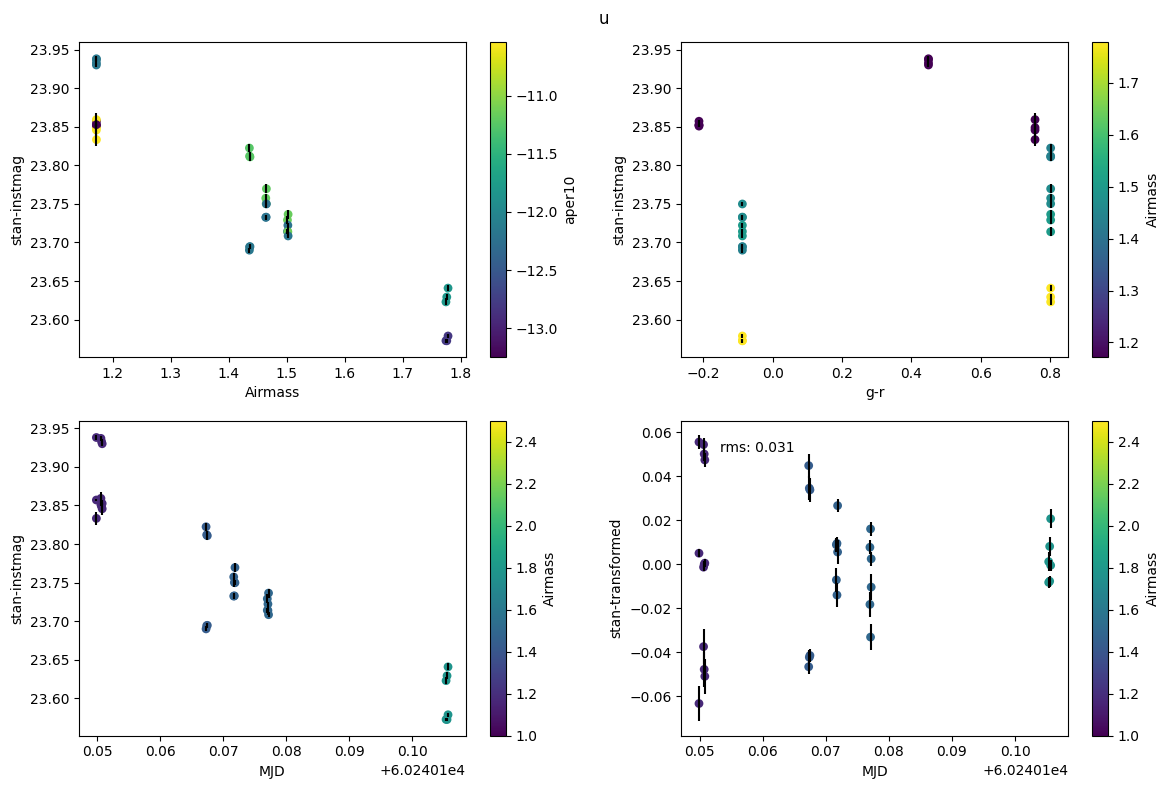

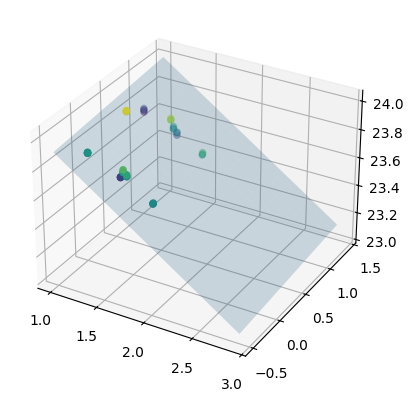

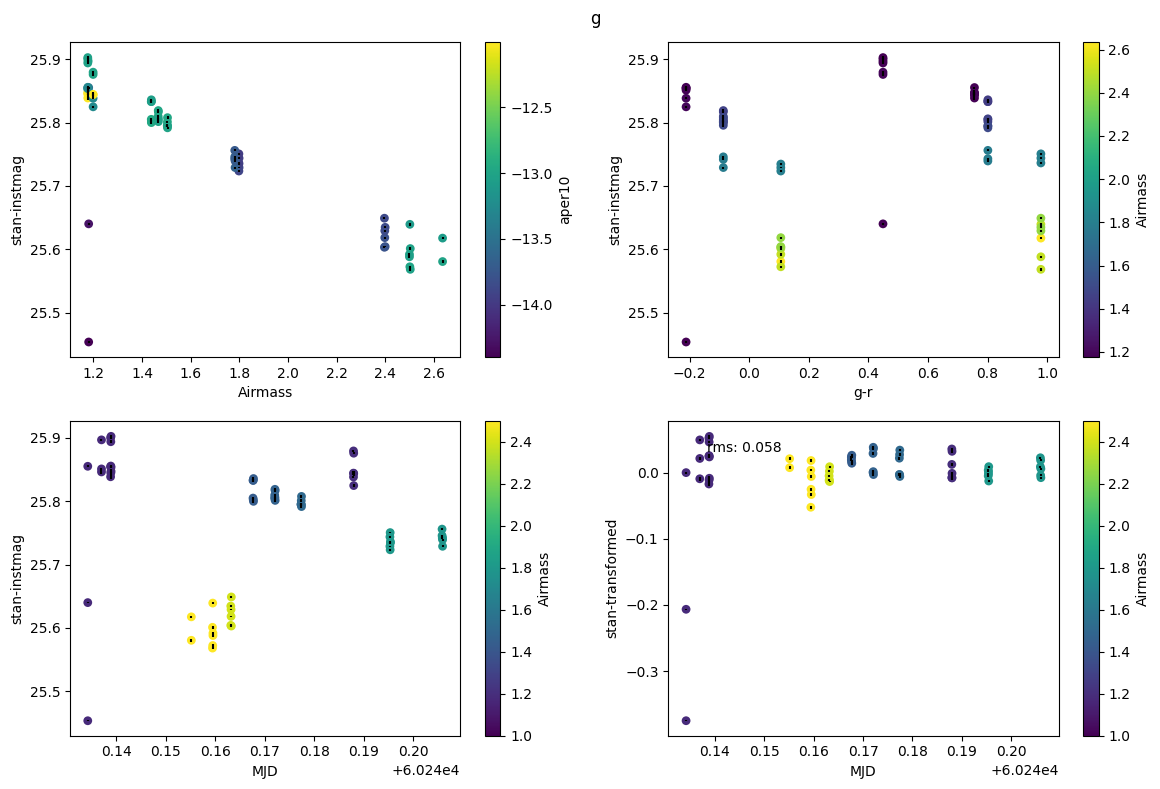

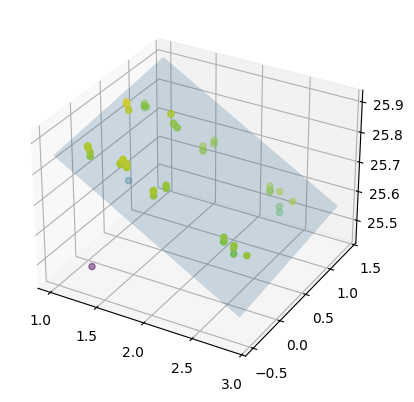

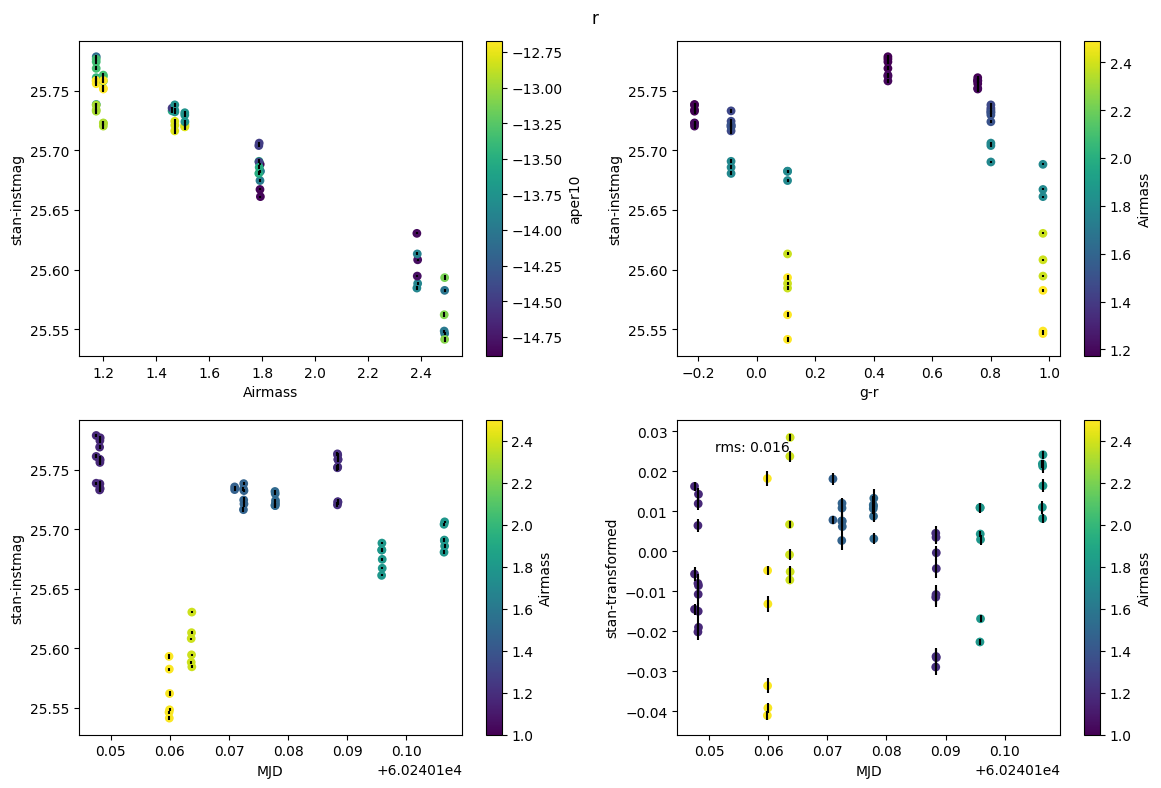

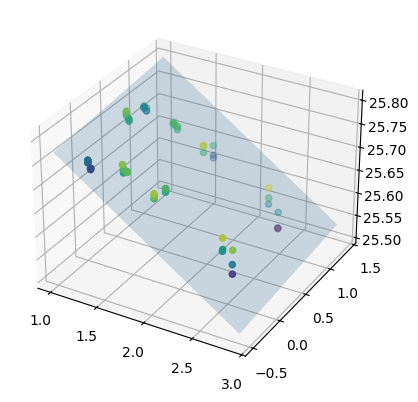

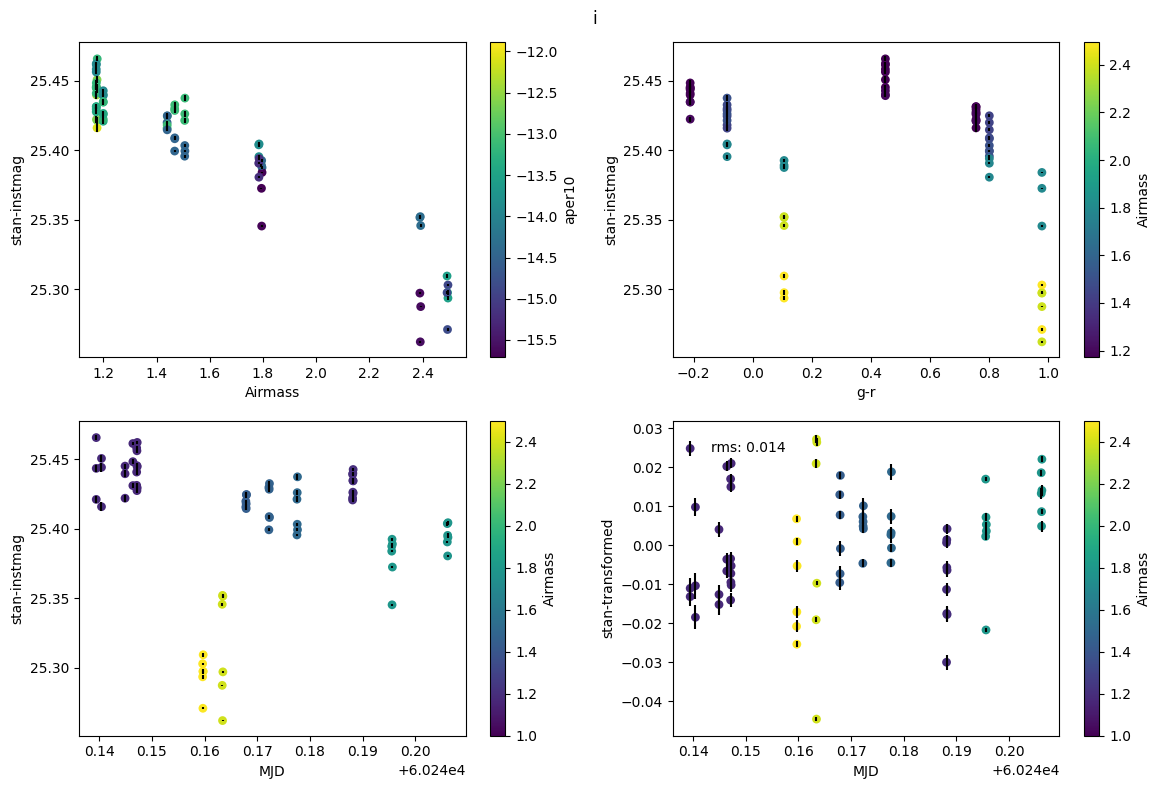

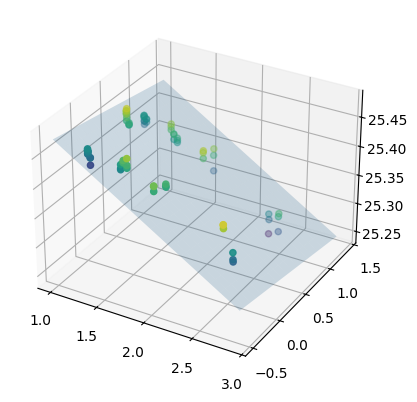

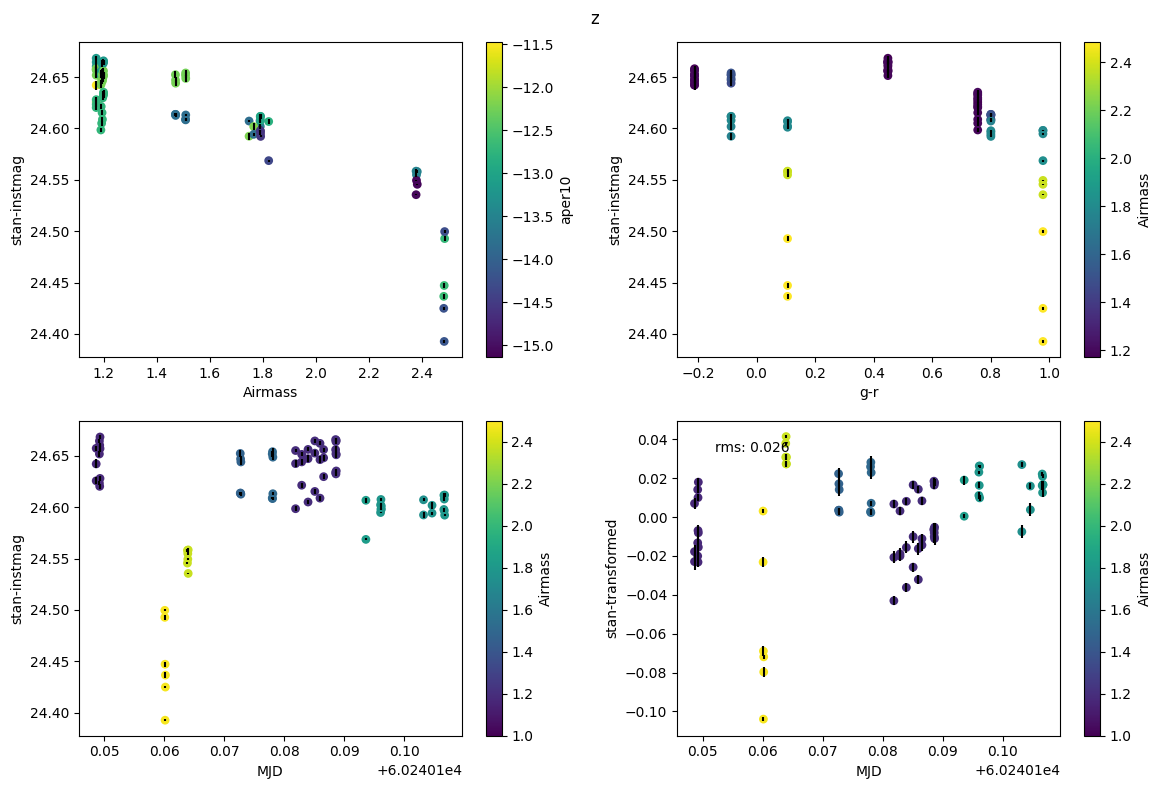

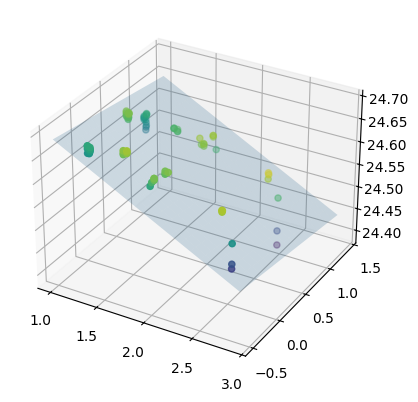

In [28]:
matplotlib.use('TkAgg')
%matplotlib inline

coeffs={}
for filt,filtname in zip(filts,filtnames) :
    # get all table entries in this filter
    gd = np.where(tab_phot['FILTER'] == filtname)[0]

    # load up instrument magnitudes, uncertainties, airmass, color, mjd, and standard mag from table
    instmag = tab_phot['aper10'][gd]+2.5*np.log10(tab_phot['EXPTIME'][gd])
    instmag_err = tab_phot['aper10err'][gd]
    airmass = tab_phot['AIRMASS'][gd]
    mjd = tab_phot['MJD'][gd]
    color = tab_phot['g'][gd]-tab_phot['r'][gd]
    stan = tab_phot[filt][gd]

    # plot stan-mag vs airmass, color, and MJD
    fig,ax=plots.multi(2,2,figsize=(12,8))
    plots.plotc(ax[0,0],airmass,stan-instmag,tab_phot['aper10'][gd],yerr=instmag_err,
                cmap='viridis',xt='Airmass',yt='stan-instmag',colorbar=True,zt='aper10',size=40)
    plots.plotc(ax[0,1],color,stan-instmag,airmass,yerr=instmag_err,
                cmap='viridis',xt='g-r',yt='stan-instmag',colorbar=True,zt='Airmass',size=40)
    plots.plotc(ax[1,0],mjd,stan-instmag,airmass,yerr=instmag_err,
                cmap='viridis',zr=[1,2.5],xt='MJD',yt='stan-instmag',colorbar=True,zt='Airmass',size=40)

    # set up and do least squares fit
    design = np.array([airmass,color,np.ones(len(gd))]).T
    rhs = stan-instmag
    fit,resid,rank,s = np.linalg.lstsq(design,rhs.value.data)
    coeffs[filt] = fit

    # use fit to calculate transformed mags, and plot stan-transformed vs MJD
    trans = instmag + fit[0]*airmass + fit[1]*color + fit[2]
    plots.plotc(ax[1,1],mjd,stan-trans, airmass,yerr=instmag_err,cmap='viridis', zr=[1,2.5],
                xt='MJD',yt='stan-transformed',zt='Airmass',size=40,colorbar=True)
    ax[1,1].text(0.1,0.9,'rms: {:.3f}'.format((stan-trans).std()),transform=ax[1,1].transAxes)
    
    fig.suptitle(filt)
    fig.tight_layout()

    # 3D plot of stan-instmag vs airmass and color, with best fit plane
    ax=plt.figure().add_subplot(projection='3d')
    ax.scatter(airmass,color,stan-instmag,marker='o',c=stan-trans,cmap='viridis')
    yy,xx=np.mgrid[-0.5:1.5:0.1,1:3:0.1]
    ax.plot_surface(xx,yy,fit[0]*xx+fit[1]*yy+fit[2],alpha=0.2)
    

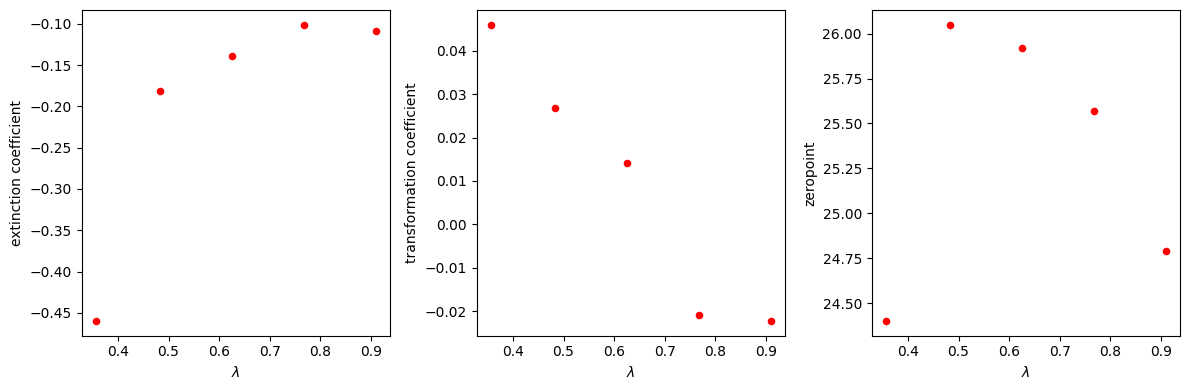

In [29]:
l_eff= np.array([0.356,0.483,0.626,0.767,0.910])
fig,ax=plots.multi(3,1,figsize=(12,4))
for l,filt in zip(l_eff,filts) :
    plots.plotp(ax[0],l,coeffs[filt][0],size=30,xt='$\lambda$',yt='extinction coefficient')
    plots.plotp(ax[1],l,coeffs[filt][1],size=30,xt='$\lambda$',yt='transformation coefficient')
    plots.plotp(ax[2],l,coeffs[filt][2],size=30,xt='$\lambda$',yt='zeropoint')
fig.tight_layout()